In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [2]:
df = pd.DataFrame(columns=['type', 'fold', 'img_path', 'mask_path'])
for i in [1, 2, 3, 4, 5]:
    for d in ['train', 'val', 'test']:
        imgs  = []
        masks = []
        for f in os.listdir(f'data/Fold{i}/{d}'):
            imgs.append(f'data/Fold{i}/{d}/{f}')

        for f in os.listdir(f'data/Fold{i}/{d}annot'):
            masks.append(f'data/Fold{i}/{d}annot/{f}')
            
        l = len(os.listdir(f'data/Fold{i}/{d}'))
        for j in range(l):
            img_path  = imgs[j]
            mask_path = masks[j]
            df = pd.concat([df, pd.DataFrame([[d, f'Fold{i}', img_path, mask_path]], columns=['type', 'fold', 'img_path', 'mask_path'])], axis=0)
df = df.reset_index(drop=True)
df

type   fold                      img_path   
0     train  Fold1   data/Fold1/train/A00010.jpg  \
1     train  Fold1  data/Fold1/train/A000100.jpg   
2     train  Fold1  data/Fold1/train/A000110.jpg   
3     train  Fold1  data/Fold1/train/A000120.jpg   
4     train  Fold1  data/Fold1/train/A000130.jpg   
...     ...    ...                           ...   
1900   test  Fold5    data/Fold5/test/a0_146.jpg   
1901   test  Fold5    data/Fold5/test/a0_147.jpg   
1902   test  Fold5    data/Fold5/test/a0_148.jpg   
1903   test  Fold5    data/Fold5/test/a0_149.jpg   
1904   test  Fold5    data/Fold5/test/a0_150.jpg   

                              mask_path  
0      data/Fold1/trainannot/A00010.png  
1     data/Fold1/trainannot/A000100.png  
2     data/Fold1/trainannot/A000110.png  
3     data/Fold1/trainannot/A000120.png  
4     data/Fold1/trainannot/A000130.png  
...                                 ...  
1900    data/Fold5/testannot/a0_146.png  
1901    data/Fold5/testannot/a0_147.png  
1902    data/Fold5/testannot/a0_148.png  
1903    data/Fold5/testannot/a0_149.png  
1904    data/Fold5/testannot/a0_150.png  

[1905 rows x 4 columns]

In [3]:
import tensorflow.keras as keras
class Dataset(keras.utils.Sequence):
    def __init__(
            self, 
            dataframe,
            batch_size=32, 
            shuffle=True
    ):
        self.df = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()    

    def __getitem__(self, ids):
        #print(self.indexes)
        indexes = self.indexes[ids*self.batch_size:(ids+1)*self.batch_size]
        #indexes = self.indexes[0:8]
        b_img  = np.empty((self.batch_size, 256, 256, 1))
        b_mask = np.empty((self.batch_size, 256, 256, 1))
        i = 0
        for j in indexes:
            img, mask = self.read_img(j)
            b_img[i, :, :, :]  = img
            b_mask[i, ...] = mask
            i = i + 1
        
        return b_img/255, b_mask
        
    def __len__(self):
        return int(len(self.df) / self.batch_size)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)      


    def read_img(self, i):
        # read data
        image = cv2.imread(self.df['img_path'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        height, width = image.shape[:2]
        # 定義裁切區域的左上角座標和右下角座標
        left = width/4
        top = 0
        right = width*(3/4)
        bottom = height*0.7
        # 將圖像轉換為 PIL.Image 物件
        pil_img = Image.fromarray(image)
        # 使用crop()方法裁切圖像
        cropped_img = pil_img.crop((left, top, right, bottom))
        image_resize = cropped_img.resize((256, 256))
        image  = np.expand_dims(image_resize, axis=2)

        mask  = cv2.imread(self.df['mask_path'][i], 0)
        # mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        height, width = mask.shape[:2]
        # 定義裁切區域的左上角座標和右下角座標
        left = width/4
        top = 0
        right = width*(3/4)
        bottom = height*0.7
        # 將圖像轉換為 PIL.Image 物件
        pil_img = Image.fromarray(mask)
        # 使用crop()方法裁切圖像
        cropped_mask = pil_img.crop((left, top, right, bottom))
        mask_resize  = cropped_mask.resize((256, 256))
        # mask  = np.where(mask>127, 1, 0) 
        #數值中小於127to0，大於127to255
        _,aa = cv2.threshold(np.array(mask_resize), 127, 1, cv2.THRESH_BINARY)
        mask  = np.expand_dims(aa, axis=2)

        return image, mask


In [4]:
fold = df[df['fold']=='Fold3'].reset_index(drop=True)

train_df = fold[fold['type']=='train'].reset_index(drop=True)
val_df   = fold[fold['type']=='val'].reset_index(drop=True)
test_df  = fold[fold['type']=='test'].reset_index(drop=True)

train_dataset = Dataset(dataframe=train_df, batch_size=8, shuffle=True)
vala_dataset  = Dataset(dataframe=val_df,batch_size=8,shuffle=True)
test_dataset  = Dataset(dataframe=test_df,batch_size=8,shuffle=True)

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(8, 3))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

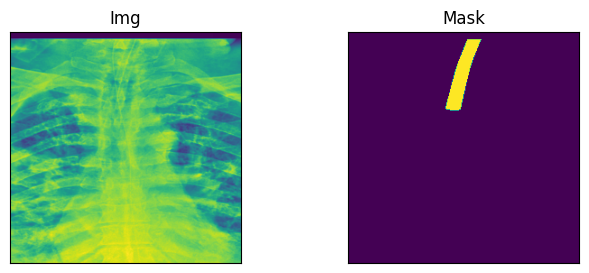

In [6]:
visualize(img=(train_dataset[0][0][3]*255).astype('int'), mask=train_dataset[0][1][3])

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, Conv2DTranspose
from coordinateAttention import coordinateAttentionLayer


number_of_filters = 2

def conv2d(filters: int):
    return Conv2D(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  kernel_regularizer=l2(0.),
                  bias_regularizer=l2(0.))


def conv2dtranspose(filters: int):
    return Conv2DTranspose(filters=filters,
                           kernel_size=(2, 2),
                           strides=(2, 2),
                           padding='same')



model_input = Input((256, 256, 1))
x00 = conv2d(filters=int(16 * number_of_filters))(model_input)
x00 = BatchNormalization()(x00)
x00 = LeakyReLU(0.01)(x00)
x00 = Dropout(0.2)(x00)
x00 = conv2d(filters=int(16 * number_of_filters))(x00)
x00 = BatchNormalization()(x00)
x00 = LeakyReLU(0.01)(x00)
x00 = Dropout(0.2)(x00)
x00 = coordinateAttentionLayer(x00, int(16 * number_of_filters), int(16 * number_of_filters))
p0 = MaxPooling2D(pool_size=(2, 2))(x00)

x10 = conv2d(filters=int(32 * number_of_filters))(p0)
x10 = BatchNormalization()(x10)
x10 = LeakyReLU(0.01)(x10)
x10 = Dropout(0.2)(x10)
x10 = conv2d(filters=int(32 * number_of_filters))(x10)
x10 = BatchNormalization()(x10)
x10 = LeakyReLU(0.01)(x10)
x10 = Dropout(0.2)(x10)
x10 = coordinateAttentionLayer(x10, int(32 * number_of_filters), int(32 * number_of_filters))
p1 = MaxPooling2D(pool_size=(2, 2))(x10)

x01 = conv2dtranspose(int(16 * number_of_filters))(x10)
x01 = concatenate([x00, x01])
x01 = conv2d(filters=int(16 * number_of_filters))(x01)
x01 = BatchNormalization()(x01)
x01 = LeakyReLU(0.01)(x01)
x01 = conv2d(filters=int(16 * number_of_filters))(x01)
x01 = BatchNormalization()(x01)
x01 = LeakyReLU(0.01)(x01)
x01 = Dropout(0.2)(x01)
x01 = coordinateAttentionLayer(x01, int(16 * number_of_filters), int(16 * number_of_filters))

x20 = conv2d(filters=int(64 * number_of_filters))(p1)
x20 = BatchNormalization()(x20)
x20 = LeakyReLU(0.01)(x20)
x20 = Dropout(0.2)(x20)
x20 = conv2d(filters=int(64 * number_of_filters))(x20)
x20 = BatchNormalization()(x20)
x20 = LeakyReLU(0.01)(x20)
x20 = Dropout(0.2)(x20)
x20 = coordinateAttentionLayer(x20, int(64 * number_of_filters), int(64 * number_of_filters))
p2 = MaxPooling2D(pool_size=(2, 2))(x20)

x11 = conv2dtranspose(int(16 * number_of_filters))(x20)
x11 = concatenate([x10, x11])
x11 = conv2d(filters=int(16 * number_of_filters))(x11)
x11 = BatchNormalization()(x11)
x11 = LeakyReLU(0.01)(x11)
x11 = conv2d(filters=int(16 * number_of_filters))(x11)
x11 = BatchNormalization()(x11)
x11 = LeakyReLU(0.01)(x11)
x11 = Dropout(0.2)(x11)
x11 = coordinateAttentionLayer(x11, int(16 * number_of_filters), int(16 * number_of_filters))

x02 = conv2dtranspose(int(16 * number_of_filters))(x11)
x02 = concatenate([x00, x01, x02])
x02 = conv2d(filters=int(16 * number_of_filters))(x02)
x02 = BatchNormalization()(x02)
x02 = LeakyReLU(0.01)(x02)
x02 = conv2d(filters=int(16 * number_of_filters))(x02)
x02 = BatchNormalization()(x02)
x02 = LeakyReLU(0.01)(x02)
x02 = Dropout(0.2)(x02)
x02 = coordinateAttentionLayer(x02, int(16 * number_of_filters), int(16 * number_of_filters))

x30 = conv2d(filters=int(128 * number_of_filters))(p2)
x30 = BatchNormalization()(x30)
x30 = LeakyReLU(0.01)(x30)
x30 = Dropout(0.2)(x30)
x30 = conv2d(filters=int(128 * number_of_filters))(x30)
x30 = BatchNormalization()(x30)
x30 = LeakyReLU(0.01)(x30)
x30 = Dropout(0.2)(x30)
x30 = coordinateAttentionLayer(x30, int(128 * number_of_filters), int(128 * number_of_filters))
p3 = MaxPooling2D(pool_size=(2, 2))(x30)

x21 = conv2dtranspose(int(16 * number_of_filters))(x30)
x21 = concatenate([x20, x21])
x21 = conv2d(filters=int(16 * number_of_filters))(x21)
x21 = BatchNormalization()(x21)
x21 = LeakyReLU(0.01)(x21)
x21 = conv2d(filters=int(16 * number_of_filters))(x21)
x21 = BatchNormalization()(x21)
x21 = LeakyReLU(0.01)(x21)
x21 = Dropout(0.2)(x21)
x21 = coordinateAttentionLayer(x21, int(16 * number_of_filters), int(16 * number_of_filters))

x12 = conv2dtranspose(int(16 * number_of_filters))(x21)
x12 = concatenate([x10, x11, x12])
x12 = conv2d(filters=int(16 * number_of_filters))(x12)
x12 = BatchNormalization()(x12)
x12 = LeakyReLU(0.01)(x12)
x12 = conv2d(filters=int(16 * number_of_filters))(x12)
x12 = BatchNormalization()(x12)
x12 = LeakyReLU(0.01)(x12)
x12 = Dropout(0.2)(x12)
x12 = coordinateAttentionLayer(x12, int(16 * number_of_filters), int(16 * number_of_filters))

x03 = conv2dtranspose(int(16 * number_of_filters))(x12)
x03 = concatenate([x00, x01, x02, x03])
x03 = conv2d(filters=int(16 * number_of_filters))(x03)
x03 = BatchNormalization()(x03)
x03 = LeakyReLU(0.01)(x03)
x03 = conv2d(filters=int(16 * number_of_filters))(x03)
x03 = BatchNormalization()(x03)
x03 = LeakyReLU(0.01)(x03)
x03 = Dropout(0.2)(x03)
x03 = coordinateAttentionLayer(x03, int(16 * number_of_filters), int(16 * number_of_filters))

x40 = conv2d(filters=int(256 * number_of_filters))(p3)
x40 = BatchNormalization()(x40)
x40 = LeakyReLU(0.01)(x40)
x40 = conv2d(filters=int(256 * number_of_filters))(x40)
x40 = BatchNormalization()(x40)
x40 = LeakyReLU(0.01)(x40)
x40 = Dropout(0.2)(x40)
x40 = coordinateAttentionLayer(x40, int(256 * number_of_filters), int(256 * number_of_filters))

x31 = conv2dtranspose(int(128 * number_of_filters))(x40)
x31 = concatenate([x31, x30])
x31 = conv2d(filters=int(128 * number_of_filters))(x31)
x31 = BatchNormalization()(x31)
x31 = LeakyReLU(0.01)(x31)
x31 = conv2d(filters=int(128 * number_of_filters))(x31)
x31 = BatchNormalization()(x31)
x31 = LeakyReLU(0.01)(x31)
x31 = Dropout(0.2)(x31)
x31 = coordinateAttentionLayer(x31, int(128 * number_of_filters), int(128 * number_of_filters))

x22 = conv2dtranspose(int(64 * number_of_filters))(x31)
x22 = concatenate([x22, x20, x21])
x22 = conv2d(filters=int(64 * number_of_filters))(x22)
x22 = BatchNormalization()(x22)
x22 = LeakyReLU(0.01)(x22)
x22 = conv2d(filters=int(64 * number_of_filters))(x22)
x22 = BatchNormalization()(x22)
x22 = LeakyReLU(0.01)(x22)
x22 = Dropout(0.2)(x22)
x22 = coordinateAttentionLayer(x22, int(64 * number_of_filters), int(64 * number_of_filters))

x13 = conv2dtranspose(int(32 * number_of_filters))(x22)
x13 = concatenate([x13, x10, x11, x12])
x13 = conv2d(filters=int(32 * number_of_filters))(x13)
x13 = BatchNormalization()(x13)
x13 = LeakyReLU(0.01)(x13)
x13 = conv2d(filters=int(32 * number_of_filters))(x13)
x13 = BatchNormalization()(x13)
x13 = LeakyReLU(0.01)(x13)
x13 = Dropout(0.2)(x13)
x13 = coordinateAttentionLayer(x13, int(32 * number_of_filters), int(32 * number_of_filters))

x04 = conv2dtranspose(int(16 * number_of_filters))(x13)
x04 = concatenate([x04, x00, x01, x02, x03], axis=3)
x04 = conv2d(filters=int(16 * number_of_filters))(x04)
x04 = BatchNormalization()(x04)
x04 = LeakyReLU(0.01)(x04)
x04 = conv2d(filters=int(16 * number_of_filters))(x04)
x04 = BatchNormalization()(x04)
x04 = LeakyReLU(0.01)(x04)
x04 = Dropout(0.2)(x04)
x04 = coordinateAttentionLayer(x04, int(16 * number_of_filters), int(16 * number_of_filters))


output = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(x04)
model_Fold3 = tf.keras.Model(inputs=[model_input], outputs=[output])
model_Fold3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam 
from loss import iou, weighted_loss, cce_iou_dice
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [9]:
from tensorflow.keras.optimizers import Adam
@tf.function
def Dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return 1 - (K.mean((2. * intersection + smooth) / (union + smooth), axis=0))

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr



opt = Adam(learning_rate=1e-3)
lr_metric = get_lr_metric(opt)

metrics = [Dice, iou, lr_metric]
weights_list = {1: 1.0, 2: 50.0, 3: 70.0}
loss_function = weighted_loss(cce_iou_dice, weights_list)
model_Fold3.compile(optimizer=opt, loss=loss_function, metrics=metrics)
# model.compile(optimizer = opt, loss = bce_dice_loss, metrics=[iou])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
# 設置 ModelCheckpoint 紀錄最佳權重
model_checkpoint    = ModelCheckpoint('Unetpp_Fold3_best.h5', save_best_only=True, save_weights_only=True)
# 學習率下降
reduce_lr           = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.00005)
# 提早停止
early_stopping      = EarlyStopping(monitor='val_loss', patience=10)


# 訓練模型
history3 = model_Fold3.fit(train_dataset, epochs=250, validation_data=vala_dataset, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/250
35/35 [==============================] - 90s 2s/step - loss: 5.4831 - Dice: 0.9086 - iou: 0.0482 - lr: 1.0000e-03 - val_loss: 6.8083 - val_Dice: 0.9534 - val_iou: 0.0239 - val_lr: 0.0010
Epoch 2/250
35/35 [==============================] - 53s 1s/step - loss: 4.7920 - Dice: 0.8750 - iou: 0.0672 - lr: 1.0000e-03 - val_loss: 6.9160 - val_Dice: 0.9559 - val_iou: 0.0226 - val_lr: 0.0010
Epoch 3/250
35/35 [==============================] - 53s 1s/step - loss: 4.2735 - Dice: 0.8399 - iou: 0.0894 - lr: 1.0000e-03 - val_loss: 6.7760 - val_Dice: 0.9527 - val_iou: 0.0242 - val_lr: 0.0010
Epoch 4/250
35/35 [==============================] - 53s 1s/step - loss: 3.3218 - Dice: 0.7601 - iou: 0.1542 - lr: 1.0000e-03 - val_loss: 6.6471 - val_Dice: 0.9496 - val_iou: 0.0259 - val_lr: 0.0010
Epoch 5/250
35/35 [==============================] - 53s 1s/step - loss: 2.7152 - Dice: 0.6858 - iou: 0.2173 - lr: 1.0000e-03 - val_loss: 7.5993 - val_Dice: 0.9686 - val_iou: 0.0160 - val_lr: 0.0010
Epoch

In [17]:
model_Fold3.evaluate(test_dataset)

5/5 [==============================] - 9s 2s/step - loss: 0.6707 - Dice: 0.2322 - iou: 0.6703 - lr: 5.0000e-05


[0.6706665754318237,
 0.2322094887495041,
 0.6703211069107056,
 4.999999509891495e-05]

In [19]:
import pandas as pd
evl=pd.DataFrame([
                history3.history['loss'],
                history3.history['Dice'],
                history3.history['iou'],
                history3.history['lr'],
                history3.history['val_loss'],
                history3.history['val_Dice'],
                history3.history['val_iou'],
                history3.history['val_lr']]).T
evl.columns=["loss(weighted_loss)","Dice","iou","lr","val_loss(weighted_loss)","val_Dice","val_iou","val_lr"]
evl.to_csv('fold3_.csv',index=False)

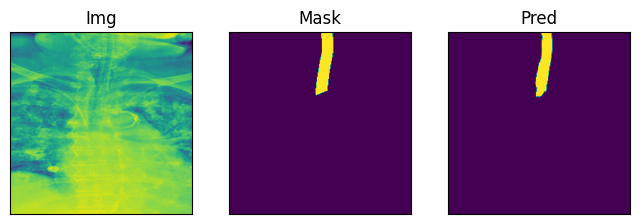

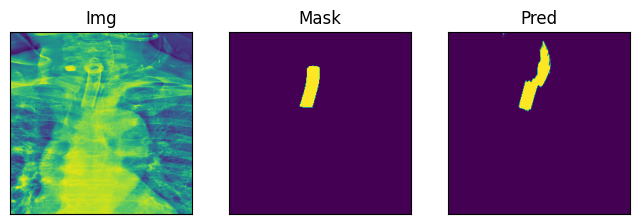

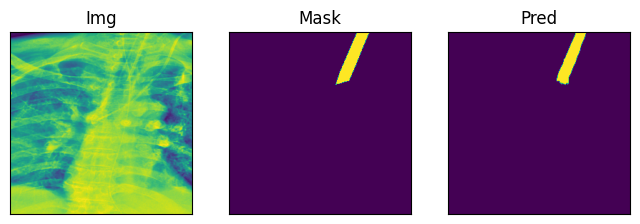

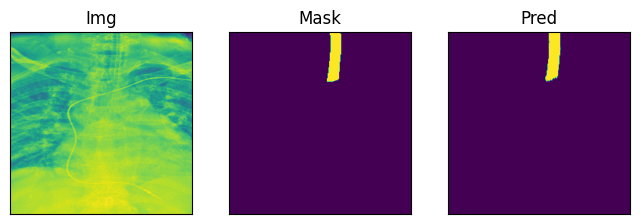

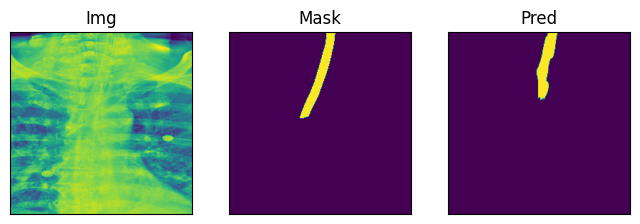

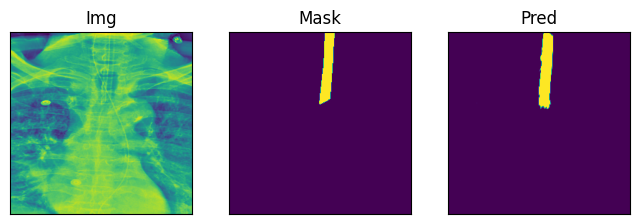

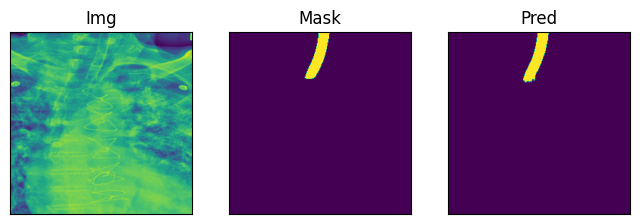

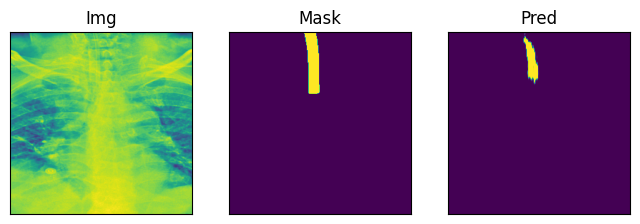

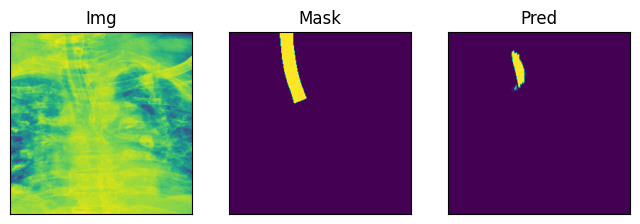

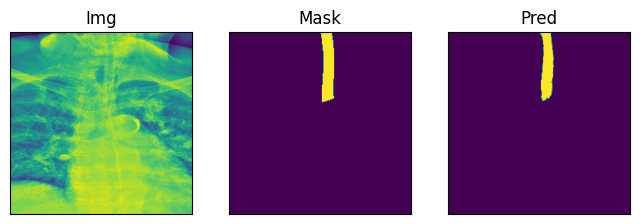

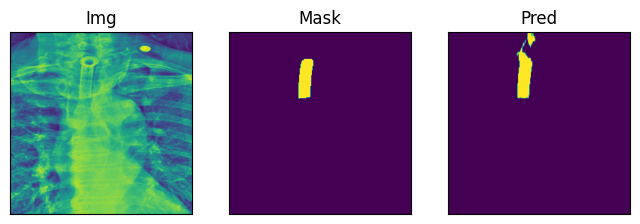

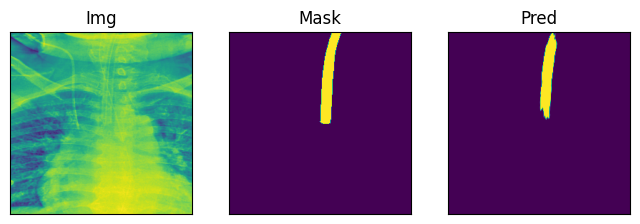

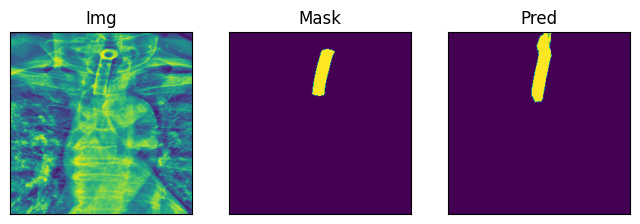

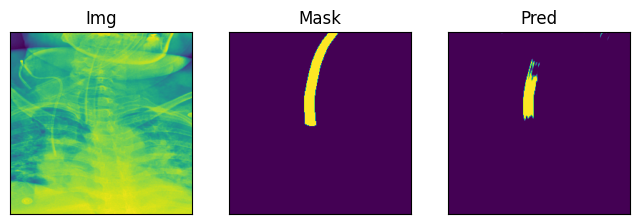

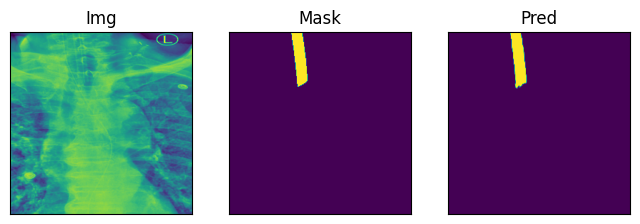

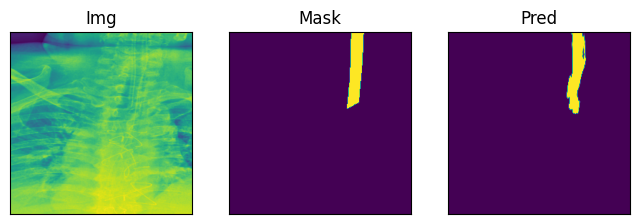

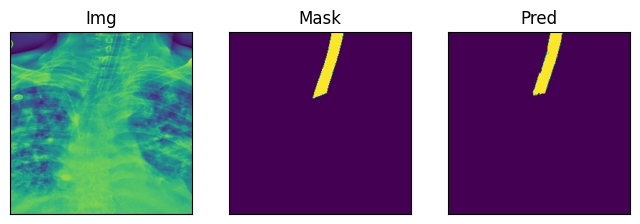

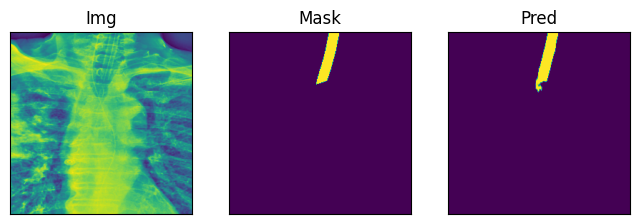

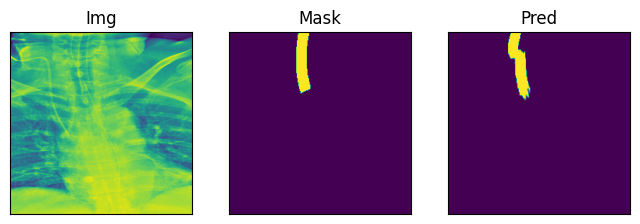

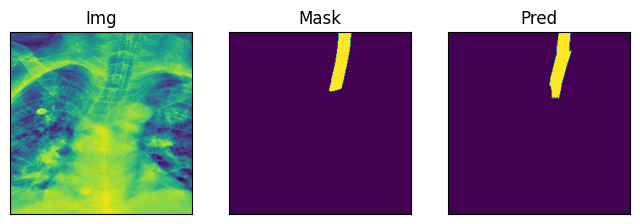

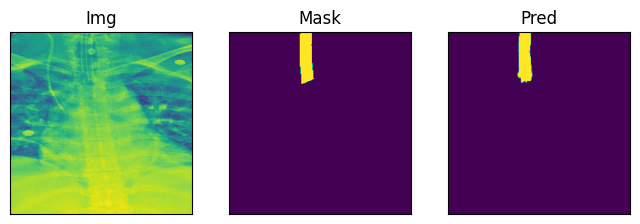

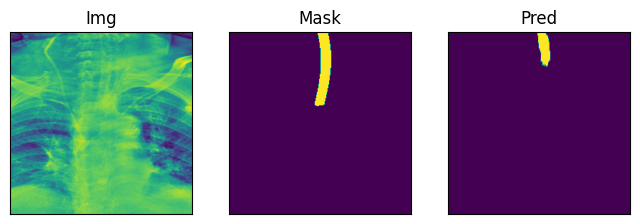

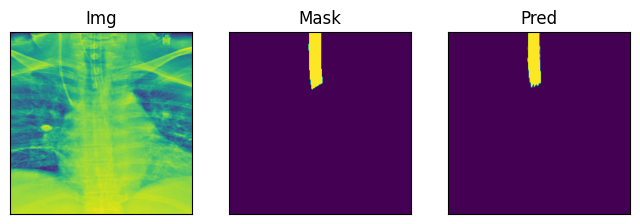

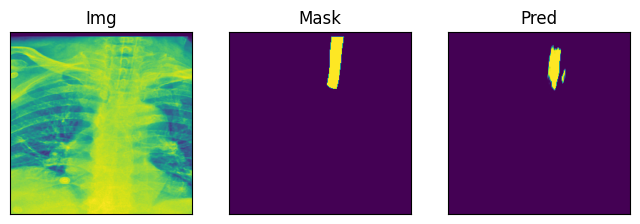

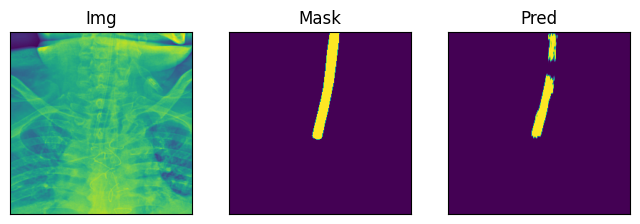

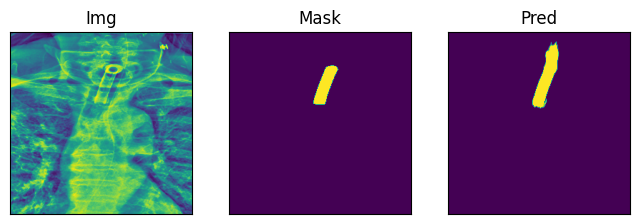

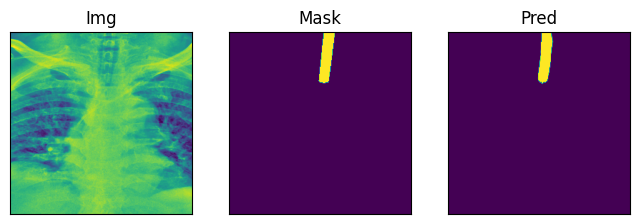

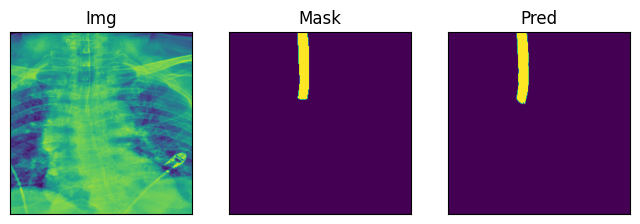

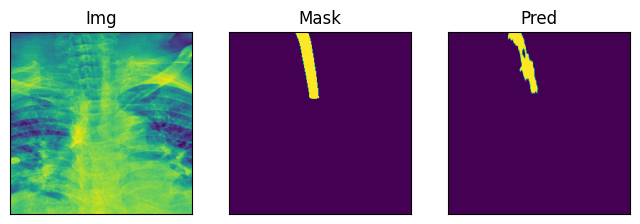

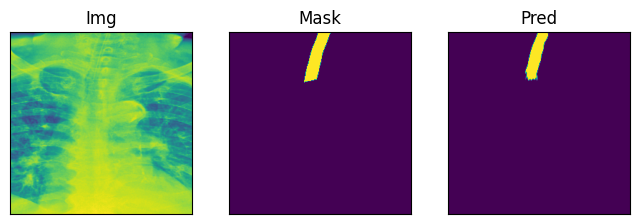

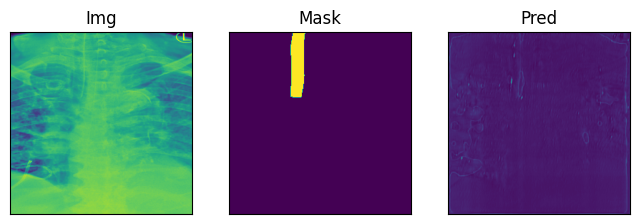

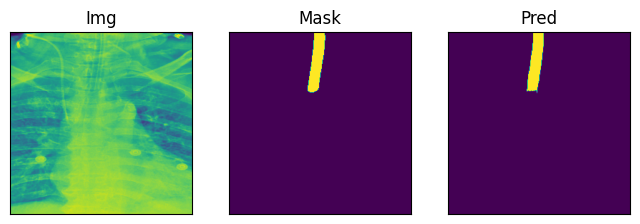

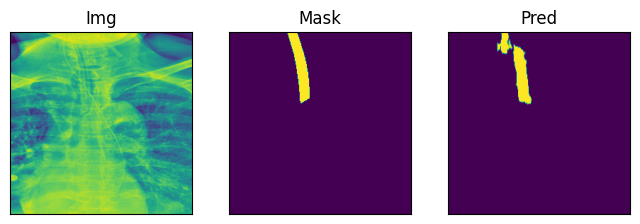

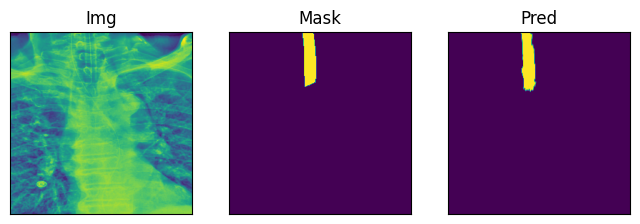

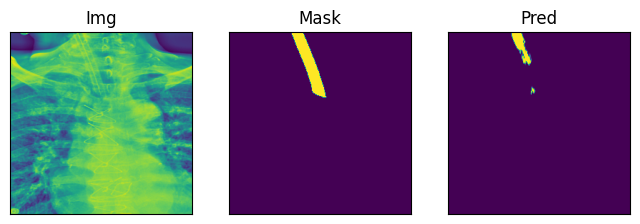

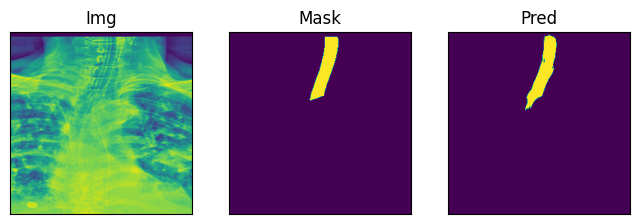

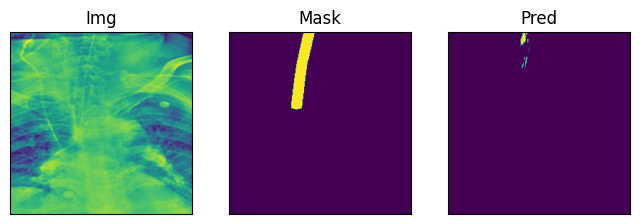

In [12]:
a = 0
for img, mask in test_dataset:
    mask_pred =model_Fold3.predict(img)
    img = img * 255
    for i in range(mask_pred.shape[0]):
        visualize(img=img[i].astype('int'), mask=mask[i], pred=mask_pred[i])
    if a>15:
        break
    a =a +1

In [13]:
def read_img_size(imgpath):
    # os.mkdir('%s_New'%(imgpath))
    image_folder = imgpath
    images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    image_cropSize_list = []
    image_orlSize_list = []
    for img in images:
        orl_img = cv2.imread(img)
        image = cv2.cvtColor(orl_img, cv2.COLOR_BGR2GRAY)
        orl_img_shape = np.array(image).shape
        image_orlSize_list.append(np.array(orl_img_shape))

        height, width = image.shape[:2]
        # 定義裁切區域的左上角座標和右下角座標
        left = width/4
        top = 0
        right = width*(3/4)
        bottom = height*0.7
        # 將圖像轉換為 PIL.Image 物件
        pil_img = Image.fromarray(image)
        # 使用crop()方法裁切圖像
        cropped_img = pil_img.crop((left, top, right, bottom))
        cropped_img_shape = np.array(cropped_img).shape
        image_cropSize_list.append(np.array(cropped_img_shape))
    # image_array = np.array(image_list)
    return np.array(image_orlSize_list),np.array(image_cropSize_list)

In [14]:
test_img_size = read_img_size('data/Fold3/test')
testannot_img_size = read_img_size('data/Fold3/testannot')

In [18]:
pixel = 72
mean_errorYG = 0
mean_errorYGforP05 = 0
mean_errorYGforP10 = 0
total = 0
totalforP05 = 0
totalforP10 = 0
for img, mask in test_dataset:
    mask_pred =model_Fold3.predict(img)
    # img = img * 255
    # print(mask_pred.shape[0])
    for i in range(mask_pred.shape[0]):
        # visualize(img=img[i].astype('int'), mask=mask[i], pred=mask_pred[i])
        #取得testannot crop之後的大小，並對256*256的圖進行resize，還原至crop後的大小
        a,b             = testannot_img_size[1][i]
        mask_reSize     = cv2.resize(mask[i],(b,a))
        predmask_resize = cv2.resize(mask_pred[i],(b,a))

        #取得原始testannot的大小，並減去crop後的大小，反推計算crop了多少
        orla,orlb   =   testannot_img_size[0][i]
        bottom      =   int(orla-a)
        leftright   =   int((orlb-b)*0.5)

        #將預測後的圖補回crop掉的值，還原成原始圖片大小
        # Using cv2.copyMakeBorder() method
        mask_reorlSize      = cv2.copyMakeBorder(mask_reSize, 0, bottom, leftright, leftright, cv2.BORDER_CONSTANT) 
        _,mr                = cv2.threshold(mask_reorlSize, 0.5, 255, cv2.THRESH_BINARY)
        # Using cv2.copyMakeBorder() method 
        mask_pred_reorlSize = cv2.copyMakeBorder(predmask_resize, 0, bottom, leftright, leftright, cv2.BORDER_CONSTANT) 
        _,mpr               = cv2.threshold(mask_pred_reorlSize, 0.5, 255, cv2.THRESH_BINARY)


    #邊緣檢測
        #將mask_reorlSize轉換成unit8的形式
        x=cv2.convertScaleAbs(mr)
        y=cv2.convertScaleAbs(mpr)

        _,aa = cv2.threshold(x, 0.5, 255, cv2.THRESH_BINARY)
        _,bb = cv2.threshold(y, 0.5, 255, cv2.THRESH_BINARY)

        # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
        contours,  hierarchy    = cv2.findContours(image=aa, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        contours2, hierarchy2   = cv2.findContours(image=bb, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

        #尋找最長的邊緣檢測並保留，以去除其餘的雜訊
        array = []
        for i in range(len(contours2)):
            array.append(len(contours2[i]))
        maxlen = np.argmax(array)  
        Newcontours2 = contours2[maxlen]

        # # draw contours on the original image
        image_copy  = mr.copy()
        image_copy2 = mpr.copy()
        # # print(contours)
        cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255))
        cv2.drawContours(image=image_copy2, contours=Newcontours2, contourIdx=-1, color=(255))


    #誤差評估
        #取得mask端點的y座標
        mask_has_ones = np.any(image_copy == 255, axis=1)
        #取得pre_mask端點的y座標
        pre_has_ones = np.any(image_copy2 == 255, axis=1)
        
        mask_ylen = np.max(np.where(mask_has_ones)[0])
        pred_ylen = np.max(np.where(pre_has_ones)[0])
        loss_ylen = (np.absolute(int(pred_ylen)-int(mask_ylen)))

        #平均誤差公分
        mean_errorYG += loss_ylen
        total += 1

        #誤差在0.5cm內準確率
        if(loss_ylen<=(pixel/2)):
            # mean_errorYGforP05 += loss_ylen
            totalforP05 += 1
        if(loss_ylen<=(pixel)):
            # mean_errorYGforP05 += loss_ylen
            totalforP10 += 1

mean_error = (mean_errorYG/total)/pixel
print("平均誤差公分",mean_error)
print(total)
mean_errorForP05 = (totalforP05/total)*1
print("誤差在0.5cm內準確率",mean_errorForP05)
print(totalforP05)
mean_errorForP10 = (totalforP10/total)*1
print("誤差在1.0cm內準確率",mean_errorForP10)
print(totalforP10)

平均誤差公分 0.7527777777777778
40
誤差在0.5cm內準確率 0.475
19
誤差在1.0cm內準確率 0.85
34
